# `qubit_discovery` Advanced Features

In [1]:
import qubit_discovery as qd
import SQcircuit as sq
import torch

In [2]:
# Make sure to switch to PyTorch!
sq.set_engine('PyTorch')

# Set up a circuit sampler to use throughout
from qubit_discovery.optimization import CircuitSampler
sampler = CircuitSampler(
    capacitor_range=[1e-15, 12e-12],    # in F
    inductor_range=[1e-15, 5e-6],       # in H
    junction_range=[1e9, 100e9],        # in Hz
    flux_range=[0, 0.5]                   # in units of Phi_0        
)

## Constructing custom metrics

While `qubit_discovery` offers a range of pre-made metrics to construct functions with, it's easy to create new ones for custom targets you have in mind. 

All loss functions in `qubit_discovery` have the signature
```
    def my_loss_function(circuit) -> Tuple(torch.Tensor, torch.Tensor)
```
They take in a single parameter (the circuit) and return a tuple of `(loss, metric)`. The `metric` is the target you want to track. The `loss` is a function of the metric which should be minimized, and can be linearly added to the overall loss function.

For instance, to optimize for a qubit with a particular operating frequency $\omega_{01}^*$, the metric you want to track is the current qubit frequency $\omega_{01}$ whereas the loss should be something like $\mathcal{L}_\text{freq} = |\omega_{01} - \omega_{01}^*|/\omega_{01}$. (It's usually good for the loss to be unitless, especially if you're optimizing for multiple different metrics.)

In [25]:
def target_qubit_frequency_loss(circuit):
    TARGET_FREQ = 1.7 # GHz
    
    qubit_frequency = circuit.efreqs[1] - circuit.efreqs[0]
    loss = torch.abs(qubit_frequency - TARGET_FREQ)/TARGET_FREQ

    return loss, qubit_frequency

Then, we add it to the list of metrics that can be used to construct loss functions:

In [26]:
qd.losses.add_to_metrics('target_frequency', target_qubit_frequency_loss)

And after that, you can build your loss function as usual, referencing the custom metric we made with the `'target_frequency'` name. For instance,

In [27]:
my_loss_function = qd.losses.build_loss_function(
    use_losses = {'t2': 1.0, 'target_frequency': 1.0},
    use_metrics=[]
)

And optimize!

In [39]:
initial_cr = sampler.sample_circuit_code('JJ')
initial_cr.truncate_circuit(120)
initial_cr.diag(10)
print('Initial qubit frequency:', initial_cr.efreqs[1] - initial_cr.efreqs[0])

optimized_cr, _, _ = qd.optimization.run_BFGS(
    circuit=sampler.sample_circuit_code('JJ'),                         
    loss_metric_function=my_loss_function,
    max_iter=5, # We're using a simple loss function, so doesn't need many steps
    total_trunc_num=120,
    bounds=sampler.bounds
)

optimized_cr.diag(10)
print('Final qubit frequency:', optimized_cr.efreqs[1] - optimized_cr.efreqs[0])

Initial qubit frequency: tensor(68.3117, dtype=torch.float64, grad_fn=<SubBackward0>)


Iteration 3:  60%|██████    | 3/5 [00:05<00:03,  1.98s/it, loss=-1.848e-05]

Final qubit frequency: tensor(1.7000, dtype=torch.float64, grad_fn=<SubBackward0>)


---

It's easy to make more complicated metrics too. For instance, you might not care about a specific qubit frequency, but just keeping it within a range like $\omega_{10} \in [0.5, 3]$ GHz.

In [28]:
def frequency_in_range_loss(circuit):
    MIN_FREQ = 0.5
    MAX_FREQ = 3

    qubit_frequency = circuit.efreqs[1] - circuit.efreqs[0]

    if qubit_frequency < MIN_FREQ:
        loss = ((qubit_frequency - MIN_FREQ)/MIN_FREQ)**2
    elif qubit_frequency > MAX_FREQ:
        loss = ((MAX_FREQ - qubit_frequency)/MAX_FREQ)**2
    else:
        # Minor point: for gradient computation, show that the loss doesn't depend on qubit frequency (instead of just returning 0)
        loss = 0 * qubit_frequency
    
    return loss, qubit_frequency

qd.losses.add_to_metrics('frequency_range', frequency_in_range_loss)

Or instead of a specific frequency, if you have a particular spectrum you wish to achieve, just modify the first function slightly.

For the metric, we'll track the qubit frequency $f_{01}$. (The metric value is simply provided as a convenient way to track data during the optimization procedure, and does not need to be used.)

In [29]:
def target_spectrum_loss(circuit):
    TARGET_SPECTRUM = torch.tensor([0.014, 2.974, 0.194])

    circuit_spectrum = circuit.efreqs[1:4] - circuit.efreqs[0]
    loss = torch.mean(torch.abs(TARGET_SPECTRUM - circuit_spectrum)/TARGET_SPECTRUM[0])

    return loss, circuit_spectrum[0]

If you care about the circuit's spectrum at different operating points, that's also easy to do:

In [41]:
def frequency_external_flux_loss(circuit):
    EXTERNAL_FLUXES = [0, 0.5]
    TARGET_FREQS = torch.tensor([4.5, 2.0])

    # Because we're changing the operating point, that could interfere with
    # other loss functions. Any loss function should always reset the circuit
    operating_point = circuit.loops[0].value()

    # Calculate qubit frequency at other flux points
    circuit_freqs = []
    for phi_ext in EXTERNAL_FLUXES:
        circuit.loops[0].set_flux(phi_ext)
        circuit.diag(2)
        circuit_freqs.append(circuit.efreqs[1] - circuit.efreqs[0])
    circuit_freqs = torch.stack(circuit_freqs)

    # Reset the circuit
    circuit.loops[0].set_flux(operating_point / 2 / torch.pi)
    
    loss = torch.mean(torch.abs(TARGET_FREQS - circuit_freqs)/TARGET_FREQS[0])
    
    return loss, circuit_freqs[0]

Besides functions of the spectrum, SQcircuit also provides differentiable eigenvectors, decoherence and dephasing rates, coupling operators, and matrix elements. These can _**all**_ be used to construct loss functions!

In [31]:
def cavity_coupling_loss(circuit):
    gate_capacitor = sq.Capacitor(1, 'fF')

    C = circuit.elements[(0, 1)][2] # This relies on you knowing how the circuit is laid out. This is correct for 'JJ' 
    g_10 = (
        (gate_capacitor.get_value('fF') / C.get_value('fF')) 
        * torch.abs(circuit.evecs[1].conj()
                    @ circuit.charge_op(1)
                    @ circuit.evecs[0])
    )

    return -g_10, g_10

qd.losses.add_to_metrics('coupling', cavity_coupling_loss)


In [32]:
def cap_quasi_t1_loss(circuit):
    """Focus on just the capacitive and quasiparticle decoherence channels.
    """
    dec_rate_cap = circuit.dec_rate('capacitive', (0, 1))
    dec_rate_quasi = circuit.dec_rate('quasiparticle', (0, 1))

    dec_rate_total = dec_rate_cap + dec_rate_quasi
    dec_time = 1 / dec_rate_total

    return dec_rate_total, dec_time  # Want to minimize the dec rate, so return that as loss. This is not normalized though

qd.losses.add_to_metrics('t1_cap_quasi', cap_quasi_t1_loss)

## Choosing elements to optimize

Suppose you have a symmetric flux-tunable transmon with $E_{J_1} = E_{J_2}$ fixed at 10 GHz, and you're forced to have $\phi_\text{ext} = \Phi_0/2$, but are free to alter the capacitance. How do you optimize that keeping these fixed?

One option is to make a sampler where the fixed values are hard-coded in the bounds. In order to _keep_ the elements at these values during optimization, we should **not** optimize over those values. This is indicated using the `elems_not_to_optimize` parameter of the sampler.

In [10]:
sampler2 = CircuitSampler(
    capacitor_range=[1e-15, 12e-12],    # in F
    inductor_range=[1e-15, 5e-6] ,      # doesn't matter in this case
    junction_range=[10e9, 10e9],        # no freedom!
    # junction_range=[9.8e9, 10.2e9]    # or maybe there's some variation?
    flux_range=[0.5, 0.5],
    elems_not_to_optimize=[sq.Junction, sq.Loop]
)

cr = sampler2.sample_circuit_code('JJ')

This is also easy enough to do by hand, if desired.

When constructing a circuit to optimize by hand, use the `requires_grad` parameter for the elements to choose if you want to optimize that element (`True`) or not (`False`).

In [13]:
loop = sq.Loop(0.5, requires_grad=False)                        # do not optimize!
JJ1 = sq.Junction(10, 'GHz', loops=[loop], requires_grad=False) # do not optimize!
JJ2 = sq.Junction(10, 'GHz', loops=[loop], requires_grad=False) # do not optimize!

# For the element to optimize, either start at reasonable value, or generate randomly
C = sq.Capacitor(10, 'fF', requires_grad=True)                  # DO optimize!

cr = sq.Circuit(
    {(0, 1): [JJ1, JJ2, C]}
)

This circuit can be optimized just like any other, though you'll need to supply the bounds by hand (rather than taking from the sampler).

In [21]:
_ = qd.optimization.run_BFGS(
    circuit = cr,
    loss_metric_function=my_loss_function,
    max_iter=5,
    total_trunc_num=120,
    bounds={sq.Capacitor: torch.tensor([1e-15, 1e-14])} # You must give bounds for all the element types you're optimizing over
)

Iteration 1:  20%|██        | 1/5 [00:01<00:07,  1.89s/it, loss=3.558e+00]


Constructing circuits by hand like this also provide more fine-grained control over which elements to optimize (e.g., if you want to optimize some junctions, but not others).

## Using different optimizers

In [3]:
# Make a very simple loss function for below examples.
my_loss_function = qd.losses.build_loss_function(
    use_losses = {'number_of_gates': 1.0},
    use_metrics = []
)

The hyperparameters for gradient descent and BFGS have been sensibly chosen, but you may want to change them for your particular problem. It's as easy as passing in a `optimizer_kwargs` dict to `run_[SGD/BFGS]()`.

These keywords go directly to initializing the [`torch.optim.SGD`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) or [`torch.optim.LBFGS`](https://pytorch.org/docs/stable/generated/torch.optim.LBFGS.html) optimizer.

In [12]:
cr = sampler.sample_circuit_code('JL')
_ = qd.optimization.run_SGD(
    circuit=cr,                          
    loss_metric_function=my_loss_function,
    max_iter=50,
    total_trunc_num=300,
    bounds=sampler.bounds,
    optimizer_kwargs={ # These hyperparamters are illustrative, and may not work well
        'lr': 1e-2,
        'nesterov': True,
        'momentum': 0.1
    }
)

Iteration 49: 100%|██████████| 50/50 [00:28<00:00,  1.74it/s, loss=4.587e-03]


In [47]:
cr = sampler.sample_circuit_code('JL')
_ = qd.optimization.run_BFGS(
    circuit=cr,                          
    loss_metric_function=my_loss_function,
    max_iter=50,
    total_trunc_num=300,
    bounds=sampler.bounds,
    optimizer_kwargs={ # These hyperparamters are illustrative, and may not work well
        'lr': 2,
        'tolerance_change': 1e-8
    }
)

Iteration 20:  40%|████      | 20/50 [01:50<02:46,  5.54s/it, loss=1.564e-06]


Additionally, `qubit_discovery` supports other PyTorch optimizers. Using `qd.optimization.run_optimization`, you can pass in in a PyTorch [Optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Optimizer) as well as a set of keyword arguments to initialize it.

Below we'll try out Adam, a popular algorithm for neural networks.

In [21]:
cr = sampler.sample_circuit_code('JL')
_ = qd.optimization.run_optimization( 
## Same as run_[BFGS/SGD]
    circuit=cr,                          
    loss_metric_function=my_loss_function,
    max_iter=50,
    total_trunc_num=300,
    bounds=sampler.bounds,
## Parameters to set up the optimizer
    optimizer=torch.optim.Adam,                 # The PyTorch optimizer you wish to use
    optimizer_kwargs={                          # Defaults parameters you want to change when initializing the optimizer
        'lr':  1e-2,
        'betas': (0.8, 0.9)
    },
    uses_closure=False                          # Whether the requires a closure (e.g. LBFGS, conjugate gradient, …) or not
                                                # (e.g. most first-order methods).
)

Iteration 49: 100%|██████████| 50/50 [00:28<00:00,  1.77it/s, loss=9.482e+00]


## A bit more on truncation

Recall that `qubit_discovery.optimization.assign_trunc_nums` assigns truncation numbers to a (already diagonalized circuits) by estimating which modes participate most in the low energy states.

If you just want to get these estimated truncation numbers (but not necessarily set the circuit to them), use `trunc_num_heuristic`. (This only works for a circuit with at least 2 modes.)

In [25]:
# An example (randomly sampled) 'JLL' circuit

loop = sq.Loop(0.5)
cr = sq.Circuit(
    {
        (0, 1): [sq.Junction(56, 'GHz', loops=[loop]), sq.Capacitor(3e-15, 'F')],
        (1, 2): [sq.Inductor(9.6e-12, 'H', loops=[loop]), sq.Capacitor(2.4e-14, 'F')],
        (2, 0): [sq.Inductor(6e-09, 'H', loops=[loop]), sq.Capacitor(6.5e-14, 'F')]
    },
    flux_dist='junctions'
)
cr.description()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [27]:
# Must diagonalize a circuit first before estimating optimal truncation numbers
K = 700
cr.truncate_circuit(K)
cr.diag(10)
qd.optimization.trunc_num_heuristic(cr, K=K)

[5, 140]

For a "JLL" circuit as above, there are two harmonic modes. The Hamiltonian is expressed in the product basis $\ket{i_1}\otimes\ket{j_2}$ where $\ket{i_1}$ (resp. $\ket{j_2}$) is a basis vector for the first (resp. second) mode. We can also express the eigenvectors in this basis

$$ \ket{1} = \sum_{i, j}c_{ij}\ket{i_1}\ket{j_2} $$

Part of the algorithm in to estimate the optimal truncation numbers is plotting the portion of the eigenvector in each mode,
$$ [\ket{1}_{[1]}]_\ell := \max_j c_{\ell j},\quad [\ket{1}_{[2]}]_\ell := \max_i c_{i \ell} $$
(See the paper [TODO] for more explanation.)

By passing in a set of axes to `trunc_num_heuristic`, you can get plots of $|\ket{1}_{[1]}|$ and $|\ket{1}_{[2]}$.

[5, 140]

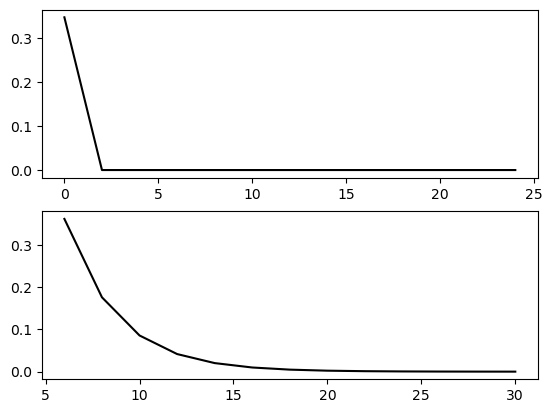

In [28]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 1) ## Number of axes should match the number of harmonic modes in the circuit
qd.optimization.trunc_num_heuristic(cr, K=K, axes=axs)

Here, the fast decay of the part of $\ket{1}$ in the first mode, $|\ket{1}_{[1]}|$, indicates the first mode participates less in $\ket{1}$ (which matches the intuition that the characteristic frequency of the first mode is much higher than the second, as we saw in the circuit description above). Hence, the first mode is allocated a much lower truncation number (5 vs. 140).

## Verbose output

The progress bar is cute when running a notebook, but if you're using `run_BFGS`, etc. in a script you might want more information printed out during optimization.

`qubit_discovery` uses Python's `logging` module to output details during optimization. If you know how to use the `logging` library, call `qubit_discovery.get_logger()` and add handlers to your heart's content.

If you don't, we provide a convenience function which sets all this data to print out when generated.

In [5]:
qd.log_to_stdout()

<Logger qubit_discovery (INFO)>

In [6]:
# Perform one step to see the information which is printed now

cr = sampler.sample_circuit_code('JL')
_ = qd.optimization.run_BFGS(
    circuit=cr,                          
    loss_metric_function=my_loss_function,
    max_iter=1,
    total_trunc_num=300,
    bounds=sampler.bounds,
)

Iteration 0:   0%|          | 0/1 [00:00<?, ?it/s, loss=2.374e-03]

[2024-08-07 02:05:43] ------------------------------------------------------------------------------------------
Optimization progress
iteration: 0
params: [0.58997997 0.89159062 1.3396255  2.8956784 ]
circuit params: [array(5.7521048), array(2.66903995e+11), array(9.13242661e-10), array(1.15175671e-15)]
loss: 0.002374254100354516
[2024-08-07 02:05:43] 	number_of_gates_loss: 0.002374254100354516
[2024-08-07 02:05:43] 	total_loss: 0.002374254100354516


Iteration 0: 100%|██████████| 1/1 [00:03<00:00,  3.45s/it, loss=2.374e-03]
